# Few Remarks
If you liked the notebook I want you to do something for me please: drop a star, leave a comment and be sure to tell somebody you love! \
Alright I'll catch you in the next one!

P.S: I spend much time on this projects, some feedback or support would be truly appreciated! 🥹

P.P.S.: check also on [GitHub](https://github.com/santurini/SimSiam-Tensorflow) and suggest me more SSL cool frameworks pls!

In [ ]:
%pip install -q einops
import tensorflow as tf
from tensorflow.keras import layers, losses
from einops import *
from einops.layers.tensorflow import EinMix as Mix

# Overview

In this notebook we are going to implement a famous framework of contrastive learning that was introduced in the following paper whose reading I recommend: [SimSiam: Exploring Simple Siamese Representation Learning](https://arxiv.org/abs/2011.10566). 

#### What is Self-supervised Learning?

Self-supervised learning consists in training a model on a generic task with generic labels (free to obtain) in order to teach the model a common visual sense of the object rather than specific patterns as in supervised learning.

The generic task is also called *Pretext Task*, for instance we can rotate the image and let the model guess the degree angle. In order to answer the model will learn a visual commonsense of the object and also rotation invariance.

In the pretext task we have no notion of score, we only care about learning good representations that will then be used in a downstream task (i.e. image classification) on a small labeled dataset.

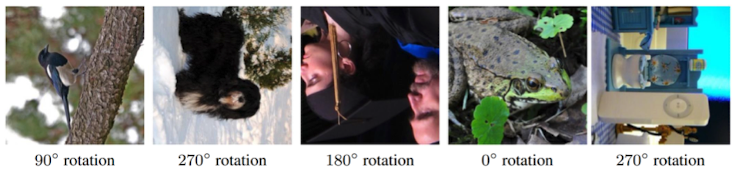

#### And what is Contrastive Learning?

Contrastive Learning is a specific technique of Self-supervised learning in which we train the encoder by passing to each branch a different augmentation of the input as positive sample and augmentations of other samples as negative examples. The idea is training the encoder to attract positive samples and repulse negative samples. The architecture is usually something like this (this is [SimCLR](https://arxiv.org/abs/2002.05709)):

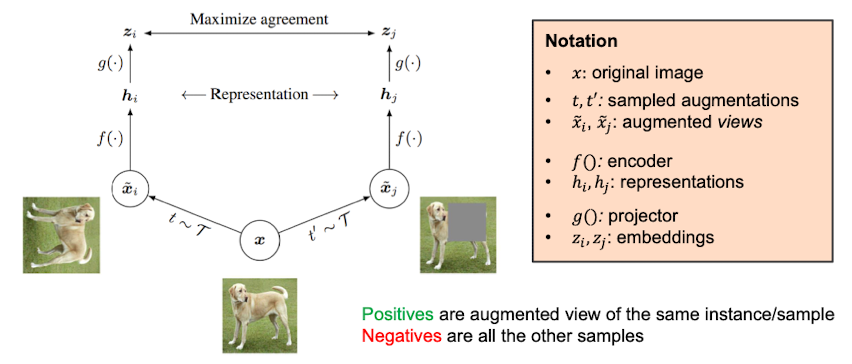

#### What is different in SimSiam?

The difference of SimSiam with respect to traditional Contrastive Learning is that it doesn't uses negative samples, in general this should lead to the collapse of representations towards a same constant for all classes but in SimSiam this is avoided by introducing the stop gradient in the right branch and using an additional predictor head (in this implementation we are going to use a symmetric architecture as the authors suggest) to learn better representations:

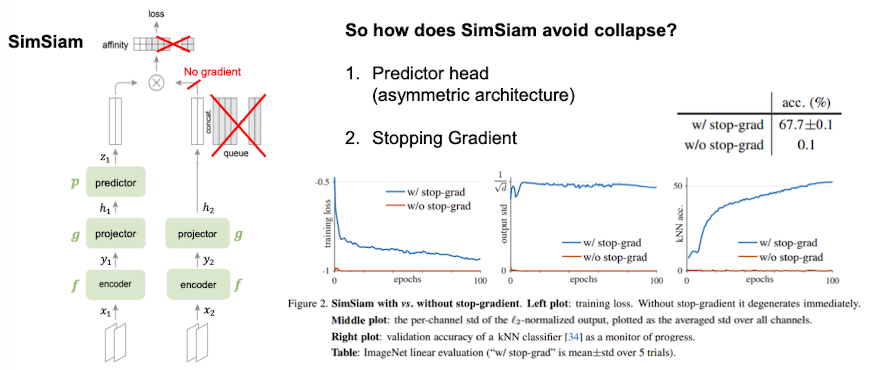

# Contrastive Loss
The contrastive loss is just a negative cosine similarity between the prediction and the representation of opposite branches, therefore we need to implement the general formula (that we will implement here and call $D$) that will then be used in its extended version in the train_step of the model class after applying stop gradient on $z_1$ and $z_2$:

$$L=\frac{1}{2}D(p_1, z_2) + \frac{1}{2}D(p_2, z_1)$$

In [ ]:
#@title contrastive loss
class ContrastiveLoss(losses.Loss):
  def __init__(self):
    super().__init__()

  def call(self, p, z):
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    return - reduce(einsum(p, z, 'b d, b d -> b'), 'b -> 1', 'mean')

# Backbone aka Target Model
The backbone is the model we want to pretrain with the pretext task in order to teach the general features of an object and the invariances that will tested later on a downstream task. In this case I'm using a mixture between the concepts of YOLO's Darknet and ResNet.

In [ ]:
#@title backbone

#@title convolution
class Conv(layers.Layer):
    def __init__(self, filters, kernel, *args, **kwargs):
        super().__init__(*args)
        self.conv = layers.Conv2D(filters, kernel, **kwargs, padding='same', use_bias=False)
        self.ln = layers.BatchNormalization()
        self.selu = layers.Activation('relu')
        
    def call(self, inputs, training=False):
        inputs = self.conv(inputs, training=training)
        inputs = self.ln(inputs, training=training)
        inputs = self.selu(inputs)
        
        return inputs

#@title residual connection
class ResidualConnection(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = Conv(filters, 3) 
        self.conv2 = Conv(filters*2, 3) # double the filters
    
    def call(self, inputs, training=False):
        residual = inputs
        inputs = self.conv1(inputs, training=training)
        inputs = self.conv2(inputs, training=training)
        return inputs + residual

#@title backbone
class convnet(tf.keras.Model):
    def __init__(self, classes, filters):
        super().__init__()
        self.conv_1 = Conv(filters*2, 1, name='conv1')
        self.res_1 = ResidualConnection(filters, name='res1')
        self.conv_2 = Conv(filters*4, 1, name='conv2')
        self.res_2 = ResidualConnection(filters*2, name='res2') 
        self.conv_3 = Conv(filters*2, 1, name='conv3')
        self.globalpool = layers.GlobalMaxPooling2D(name='globalpool')
        self.fc = layers.Dense(classes, activation='softmax', name='fc')
        self.maxpool = layers.MaxPooling2D()
        
    def call(self, inputs, training=False):
        inputs = self.maxpool(self.conv_1(inputs, training=training))
        inputs = self.res_1(inputs, training=training)
        inputs = self.maxpool(self.conv_2(inputs, training=training))
        inputs = self.res_2(inputs, training=training)
        inputs = self.maxpool(self.conv_3(inputs, training=training))
        inputs = self.globalpool(inputs)
        output = self.fc(inputs, training=training)

        return output

# Projector
The projector is used to replace the final classifier layer of the backbone in order to obtain as output a dense embedding of the images that is fed as input to the predictor.

In [ ]:
#@title projector
class Projector(layers.Layer):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim
  
  def build(self, shape):
    self.mlp = tf.keras.Sequential([
        Mix('b i -> b j', weight_shape='i j', i=shape[1], j=shape[1]),
        layers.BatchNormalization(),
        layers.ReLU(),
        Mix('b i -> b j', weight_shape='i j', i=shape[1], j=shape[1]),
        layers.BatchNormalization(),
        layers.ReLU(),
        Mix('b i -> b d', weight_shape='i d', i=shape[1], d=self.dim),  
    ], name='projector')

  def call(self, inputs, training=False):
    return self.mlp(inputs, training=training)      

# Predictor
The predictor outputs the final embeddings on which we compute the similarity measure with respect to the representations of the projector. Another small MLP in practice.

In [ ]:
#@title predictor
class Predictor(layers.Layer):
  def __init__(self, pred_dim):
    super().__init__()
    self.pred_dim = pred_dim
  
  def build(self, shape):
    self.mlp = tf.keras.Sequential([
        Mix('b i -> b d', weight_shape='i d', i=shape[1], d=self.pred_dim),
        layers.BatchNormalization(),
        layers.ReLU(),
        Mix('b d -> b i', weight_shape='d i', d=self.pred_dim, i=shape[1]),
    ], name='predictor')

  def call(self, inputs, training=False):
    return self.mlp(inputs, training=training)  

# SimSiam
The final model is composed by the backbone where we substitute the final classifier with the Projector Head and on top of it we have the Predictor head. In the forward call the output are the 4 vectors: $p_1, p_2, z_1, z_2$ that are then fed to the Contrastive Loss as explained before in order to update only the left branch.

In [ ]:
#@title simsiam
class SimSiam(tf.keras.Model):
  def __init__(self, dim, pred_dim):
    super().__init__()
    self.encoder = convnet(dim, 64)
    self.encoder.fc = Projector(dim)
    self.predictor = Predictor(dim)
    self.loss_tracker = tf.keras.metrics.Mean(name="loss")

  def call(self, inputs, training=False):
    x1, x2 = inputs[0][0], inputs[0][1]
    z1 = self.encoder(x1, training=training) # n x d
    z2 = self.encoder(x2, training=training) # n x d
    p1 = self.predictor(z1, training=training)
    p2 = self.predictor(z2, training=training)
    return p1, p2, tf.stop_gradient(z1), tf.stop_gradient(z2)

  def train_step(self, inputs):
    with tf.GradientTape() as tape:
      p1, p2, z1, z2 = self(inputs, training=True)
      loss = self.compiled_loss(p1, z2)*0.5 + self.compiled_loss(p2, z1)*0.5
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))
      self.loss_tracker.update_state(loss)
      return {"loss": self.loss_tracker.result()}

  @property
  def metrics(self):
    return [self.loss_tracker]

# Data Preparation
To prepare the data we need to have as input a tuple with two different augmentations of the same image, possibly heavy augmentations, while the labels are not important as we are in a self-supervised settings.

In [ ]:
#@title data preparation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.keras.utils.image_dataset_from_directory("../input/intel-image-classification/seg_train/seg_train", image_size=(64, 64), label_mode='int', batch_size=8)
test_ds = tf.keras.utils.image_dataset_from_directory("../input/intel-image-classification/seg_test/seg_test", label_mode='int', image_size=(64, 64), batch_size=1)

def augment(images, labels):
    x1, x2 = tf.image.random_flip_left_right(images), tf.image.random_flip_left_right(images)
    x1, x2 = tf.image.random_flip_up_down(x1), tf.image.random_flip_up_down(x2)
    x1, x2 = tf.image.rot90(x1), tf.image.rot90(x2)
    x1, x2 = tf.image.random_brightness(x1, max_delta=0.8), tf.image.random_brightness(x2, max_delta=0.8)
    x1, x2 = tf.image.random_contrast(x1, lower=1-0.8, upper=1+0.8), tf.image.random_contrast(x2, lower=1-0.8, upper=1+0.8)
    x1, x2 = tf.image.random_saturation(x1, lower=1-0.8, upper=1+0.8), tf.image.random_saturation(x2, lower=1-0.8, upper=1+0.8)
    x1, x2 = tf.image.random_hue(x1, max_delta=0.2), tf.image.random_hue(x2, max_delta=0.2)
    return (x1/255, x2/255), labels

train_ds = (
    train_ds
    .cache()
    .shuffle(1024, seed=0)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_ds = test_ds.map(lambda x, y: (x/255.0, y))
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Training
I trained the model using the default settings mentioned in the paper. This means using SGD with Cosine Scheduler.

In [ ]:
#@title training
simsiam = SimSiam(dim=2048, pred_dim=512)
epochs = 100

#@title loss and optimizer
loss = ContrastiveLoss()
scheduler = tf.keras.optimizers.schedules.CosineDecay(0.05, 500)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduler, momentum=0.9, decay=1e-04)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

#@title compile and train
simsiam.compile(optimizer=optimizer, loss=loss)
simsiam.fit(train_ds, epochs=epochs, callbacks=[early_stop])

# Testing
To test the model we have to extract only the encoder and replace the projector with a final classifier. At this stage we can consider three different ways to procede:
   1. Linear Protocol: Freeze the encoder and train only the final classifier   
   2. Semi-supervised: Unfreeze everything but train only on 5% of the data    
   3. Supervised: Unfreeze everything and train on the entire data (we go for this)

In [ ]:
#@title testing
train_ds = tf.keras.utils.image_dataset_from_directory("../input/intel-image-classification/seg_train/seg_train", image_size=(64, 64), label_mode='int', batch_size=8)
train_ds = train_ds.cache().shuffle(1024, seed=0).map(lambda x, y: (x/255.0, y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

classes = 6
convnet = simsiam.encoder
convnet.fc = layers.Dense(classes, activation='softmax', name='fc')
scheduler = tf.keras.optimizers.schedules.CosineDecay(0.01, 500)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduler, momentum=0.9, decay=1e-04)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)


convnet.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

convnet.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=[early_stop])